<h1>Use siamese GNN to predict the similarity of two source codes</h1>

<h3>Import dependencies</h3>

In [125]:
from tree_sitter import Language, Parser
import tree_sitter_java as ts_java
import os
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool, GINConv
import torch.nn.functional as F, torch.nn as nn
from torch_geometric.data import Batch
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
import random

In [126]:
def set_seed(seed=42):
    """Set all seeds to make results reproducible."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

<h2>Data preparation</h2>

<h3>Define constants</h3>

In [127]:
java_directory1 = './datasets/conplag_preprocessed'
java_directory2 = './datasets/ir_plag_preprocessed'
java_LANGUAGE = Language(ts_java.language())
parser = Parser(java_LANGUAGE)
csv_paths = ['./labels/conplag-labels.csv', './labels/ir_plag_labels.csv']

In [128]:
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    return df

<h3>Get AST</h3>

In [129]:
def parse_java_file(filepath):
    with open(filepath, 'r', encoding='utf8') as file:
        code = file.read()

    tree = parser.parse(bytes(code, "utf8"))
    root_node = tree.root_node

    nodes = []
    edges = []

    def traverse(node, parent_idx=None):
        idx = len(nodes)
        nodes.append(node.type)
        
        if parent_idx is not None:
            edges.append((parent_idx, idx))
        
        for child in node.children:
            traverse(child, idx)

    traverse(root_node)
    return nodes, edges

<h3>Build data for GNN</h3>

In [130]:
def build_global_vocab(java_directories, file_lists):
    all_node_types = set()

    for java_directory, file_list in zip(java_directories, file_lists):
        for file_name in file_list:
            file_path = os.path.join(java_directory, file_name)
            nodes, _ = parse_java_file(file_path)
            all_node_types.update(nodes)

    node_type_to_idx = {typ: idx for idx, typ in enumerate(sorted(all_node_types))}
    return node_type_to_idx

def create_node_features(nodes, node_type_to_idx):
    node_features = [node_type_to_idx[typ] for typ in nodes]
    return node_features

def create_graph_data(nodes, edges, node_features, embedding_layer):
    x = embedding_layer(torch.tensor(node_features))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    data = Data(x=x, edge_index=edge_index)
    return data

In [131]:
class NodeEmbeddingLayer(nn.Module):
    def __init__(self, num_node_types, embedding_dim):
        super(NodeEmbeddingLayer, self).__init__()
        self.embeddings = nn.Embedding(num_node_types, embedding_dim)

    def forward(self, node_indices):
        return self.embeddings(node_indices)
    
embedding_dim = 128

In [132]:
def prepare_data_for_pairs(pairs_df, java_directory, node_type_to_idx, embedding_layer):
    data_pairs = []
    for idx, row in pairs_df.iterrows():
        file1, file2, label = row['id1'], row['id2'], row['plagio']

        file1_path = os.path.join(java_directory, file1)
        file2_path = os.path.join(java_directory, file2)

        nodes1, edges1 = parse_java_file(file1_path)
        nodes2, edges2 = parse_java_file(file2_path)

        node_features1 = create_node_features(nodes1, node_type_to_idx)
        node_features2 = create_node_features(nodes2, node_type_to_idx)

        data1 = create_graph_data(nodes1, edges1, node_features1, embedding_layer)
        data2 = create_graph_data(nodes2, edges2, node_features2, embedding_layer)

        data_pairs.append((data1, data2, label))
        
    return data_pairs

In [133]:
pairs_df1 = load_csv(csv_paths[0])
pairs_df2 = load_csv(csv_paths[1])

file_list1 = list(set(pairs_df1['id1'].tolist() + pairs_df1['id2'].tolist()))
file_list2 = list(set(pairs_df2['id1'].tolist() + pairs_df2['id2'].tolist()))

java_directories = [java_directory1, java_directory2]
file_lists = [file_list1, file_list2]

node_type_to_idx = build_global_vocab(java_directories, file_lists)
embedding_layer = NodeEmbeddingLayer(len(node_type_to_idx), embedding_dim)

data_pairs1 = prepare_data_for_pairs(pairs_df1, java_directory1, node_type_to_idx, embedding_layer)
data_pairs2 = prepare_data_for_pairs(pairs_df2, java_directory2, node_type_to_idx, embedding_layer)

all_pairs = data_pairs1 + data_pairs2
random.shuffle(all_pairs)

test_size = int(len(all_pairs) * 0.2)
val_size = int(len(all_pairs) * 0.1)

test_pairs = all_pairs[:test_size]
val_pairs = all_pairs[test_size:test_size+val_size]
train_pairs = all_pairs[test_size+val_size:]

plagiarism_pairs = [pair for pair in train_pairs if pair[2] == 1]
non_plagiarism_pairs = [pair for pair in train_pairs if pair[2] == 0]

if len(plagiarism_pairs) > len(non_plagiarism_pairs):
    plagiarism_pairs = random.sample(plagiarism_pairs, len(non_plagiarism_pairs))
else:
    non_plagiarism_pairs = random.sample(non_plagiarism_pairs, len(plagiarism_pairs))

balanced_train_pairs = plagiarism_pairs + non_plagiarism_pairs
random.shuffle(balanced_train_pairs)

print("Data preparation complete.")
print(f"Number of pairs in training dataset: {len(balanced_train_pairs)}")
print(f"Number of pairs in validation set: {len(val_pairs)}")
print(f"Number of pairs in test set: {len(test_pairs)}")
data1, data2, label1 = data_pairs1[0]
data3, data4, label2 = data_pairs2[0]
print(f"Dataset 1 - First pair:")
print(f"  Graph 1: {data1.num_nodes} nodes, {data1.num_edges} edges")
print(f"  Graph 2: {data2.num_nodes} nodes, {data2.num_edges} edges")
print(f"  Label: {label1}")
print(f"Dataset 2 - First pair:")
print(f"  Graph 1: {data3.num_nodes} nodes, {data3.num_edges} edges")
print(f"  Graph 2: {data4.num_nodes} nodes, {data4.num_edges} edges")
print(f"  Label: {label2}")

Data preparation complete.
Number of pairs in training dataset: 846
Number of pairs in validation set: 133
Number of pairs in test set: 267
Dataset 1 - First pair:
  Graph 1: 919 nodes, 918 edges
  Graph 2: 1246 nodes, 1245 edges
  Label: 0
Dataset 2 - First pair:
  Graph 1: 108 nodes, 107 edges
  Graph 2: 109 nodes, 108 edges
  Label: 1


<h2>Model</h2>

<h3>Build GNN siamese architecture</h3>

In [134]:
# class GNNEncoder(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super(GNNEncoder, self).__init__()
#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, out_channels)

#     def forward(self, x, edge_index, batch):
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = self.conv2(x, edge_index)
#         x = global_mean_pool(x, batch)
#         return x

class GNNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim):
        super().__init__()
        nn1 = nn.Sequential(nn.Linear(in_channels, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        nn2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, out_dim))
        self.conv2 = GINConv(nn2)
        nn3 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, out_dim))
        self.conv3 = GINConv(nn3)
        nn4 = nn.Sequential(nn.Linear(out_dim, out_dim), nn.ReLU(), nn.Linear(out_dim, out_dim))
        self.conv4 = GINConv(nn4)
        nn5 = nn.Sequential(nn.Linear(out_dim, out_dim), nn.ReLU(), nn.Linear(out_dim, out_dim))
        self.conv5 = GINConv(nn5)
        
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = global_mean_pool(x, batch)

        return x

class SiameseNetwork(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SiameseNetwork, self).__init__()
        self.encoder = GNNEncoder(in_channels, hidden_channels, out_channels)

        

    def forward(self, data1, data2):
        h1 = self.encoder(data1.x, data1.edge_index, data1.batch)
        h2 = self.encoder(data2.x, data2.edge_index, data2.batch)
        return h1, h2

def contrastive_loss(h1, h2, label, margin=1.0):
    distance = F.pairwise_distance(h1, h2)
    loss = (label * torch.pow(distance, 2) + 
           (1 - label) * torch.pow(F.relu(margin - distance), 2))
    return loss.mean()

def collate_fn(pairs, device):
    data1_list, data2_list, labels = [], [], []
    for d1, d2, label in pairs:
        data1_list.append(d1)
        data2_list.append(d2)
        labels.append(label)

    batch1 = Batch.from_data_list(data1_list).to(device)
    batch2 = Batch.from_data_list(data2_list).to(device)
    labels = torch.tensor(labels, dtype=torch.float, device=device).to(device)

    return batch1, batch2, labels

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Args:
            patience (int): Cuántas épocas esperar después de la última mejora.
            min_delta (float): Mínima mejora en la métrica para ser considerada como mejora.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping triggered after {self.patience} epochs without improvement.")

<h3>Training</h3>

In [135]:
def train(model, optimizer, train_pairs, val_pairs, device, scheduler, threshold, epochs=50, batch_size=32):
    set_seed(42)
    
    best_val_loss = float('inf')
    best_model_state = None
    best_threshold = threshold
    patience = 10
    counter = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        random.Random(42 + epoch).shuffle(train_pairs)
        
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for i in range(0, len(train_pairs), batch_size):
            batch_pairs = train_pairs[i:i+batch_size]
            batch1, batch2, labels = collate_fn(batch_pairs, device)
            
            optimizer.zero_grad()
            h1, h2 = model(batch1, batch2)
            
            distances = F.pairwise_distance(h1, h2)
            loss = contrastive_loss(h1, h2, labels)
            
            loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item() * len(batch_pairs)
            
            predictions = (distances < best_threshold).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
        
        train_loss = total_loss / len(train_pairs)
        train_accuracy = correct / total if total > 0 else 0
        
        val_loss, val_accuracy = evaluate(model, val_pairs, device, best_threshold, batch_size)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs} Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy*100:.2f}% Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy*100:.2f}%")
        
        if scheduler:
            scheduler.step(val_loss)
        
        if (epoch + 1) % 5 == 0:
            new_threshold, _ = find_best_threshold(model, val_pairs, device, batch_size=batch_size)
            print(f"Updated threshold: {new_threshold:.4f}")
            best_threshold = new_threshold
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'epoch': epoch,
                'threshold': best_threshold,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy
            }
            torch.save(checkpoint, f'./models/siamese_gnn_model_epoch_{epoch+1}.pth')
            print(f"Saved best model at epoch {epoch+1} with threshold {best_threshold:.4f}")
            counter = 0
        else:
            counter += 1
            
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return best_threshold, train_losses, val_losses, train_accs, val_accs

def evaluate(model, data_pairs, device, threshold, batch_size=32):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i in range(0, len(data_pairs), batch_size):
            batch_pairs = data_pairs[i:i+batch_size]
            batch1, batch2, labels = collate_fn(batch_pairs, device)
            
            h1, h2 = model(batch1, batch2)
            loss = contrastive_loss(h1, h2, labels)
            
            total_loss += loss.item() * len(batch_pairs)
            
            distances = F.pairwise_distance(h1, h2)
            predictions = (distances < threshold).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(data_pairs)
    accuracy = correct / total if total > 0 else 0
    
    return avg_loss, accuracy

def find_best_threshold(model, dataset, device, batch_size=32, thresholds=np.linspace(0, 2, 100)):
    model.eval()
    all_preds_raw = []
    all_labels = []

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            batch_pairs = dataset[i:i+batch_size]

            batch1, batch2, labels = collate_fn(batch_pairs, device)

            h1, h2 = model(batch1, batch2)

            distances = F.pairwise_distance(h1, h2)
            all_preds_raw.extend(distances.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds_raw = np.array(all_preds_raw)
    all_labels = np.array(all_labels)

    best_threshold = None
    best_f1 = -1

    for threshold in thresholds:
        preds = (all_preds_raw < threshold).astype(int)
        f1 = f1_score(all_labels, preds)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

In [136]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [137]:
hidden_dim = 32
out_dim = 32
threshold = 0.2626
epochs = 200
batch_size = 128

In [138]:
model = SiameseNetwork(
    in_channels=embedding_dim,
    hidden_channels=hidden_dim,
    out_channels=out_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_threshold, train_losses, val_losses, train_accs, val_accs = train(
    model,
    optimizer,
    balanced_train_pairs,
    val_pairs,
    device,
    scheduler,
    threshold=threshold,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/200 Train Loss: 0.4248, Accuracy: 48.11% Val Loss: 0.5625, Accuracy: 40.60%
Saved best model at epoch 1 with threshold 0.2626
Epoch 2/200 Train Loss: 0.3637, Accuracy: 43.85% Val Loss: 0.4872, Accuracy: 42.86%
Saved best model at epoch 2 with threshold 0.2626
Epoch 3/200 Train Loss: 0.3375, Accuracy: 46.22% Val Loss: 0.4631, Accuracy: 46.62%
Saved best model at epoch 3 with threshold 0.2626
Epoch 4/200 Train Loss: 0.3246, Accuracy: 47.99% Val Loss: 0.4087, Accuracy: 52.63%
Saved best model at epoch 4 with threshold 0.2626
Epoch 5/200 Train Loss: 0.3199, Accuracy: 47.52% Val Loss: 0.4161, Accuracy: 53.38%
Updated threshold: 0.2020
Epoch 6/200 Train Loss: 0.3166, Accuracy: 47.64% Val Loss: 0.4186, Accuracy: 56.39%
Epoch 7/200 Train Loss: 0.3008, Accuracy: 47.99% Val Loss: 0.3898, Accuracy: 61.65%
Saved best model at epoch 7 with threshold 0.2020
Epoch 8/200 Train Loss: 0.2963, Accuracy: 47.16% Val Loss: 0.3820, Accuracy: 61.65%
Saved best model at epoch 8 with threshold 0.2020
Ep

<h3>Evaluation</h3>

In [139]:
def load_model_with_metadata(model_path, in_channels, hidden_dim, out_dim, device):
    loaded_model = SiameseNetwork(
        in_channels=in_channels,
        hidden_channels=hidden_dim,
        out_channels=out_dim
    ).to(device)
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    
    threshold = checkpoint.get('threshold', 0.5)
    epoch = checkpoint.get('epoch', 0)
    val_loss = checkpoint.get('val_loss', 0)
    val_accuracy = checkpoint.get('val_accuracy', 0)
    
    print(f"Loaded model from {model_path}")
    print(f"Model was saved at epoch {epoch+1} with validation loss {val_loss:.4f} and accuracy {val_accuracy*100:.2f}%")
    print(f"Using threshold: {threshold:.4f}")
    
    return loaded_model, threshold

In [146]:
loaded_model, threshold = load_model_with_metadata('./models/siamese_gnn_model_epoch_44.pth', embedding_dim, hidden_dim, out_dim, device)

Loaded model from ./models/siamese_gnn_model_epoch_44.pth
Model was saved at epoch 44 with validation loss 0.2004 and accuracy 81.95%
Using threshold: 0.2222


In [147]:
def compute_confusion_matrix(model, dataset, device, batch_size=batch_size, threshold=threshold):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            batch_pairs = dataset[i:i+batch_size]

            batch1, batch2, labels = collate_fn(batch_pairs, device)

            h1, h2 = model(batch1, batch2)

            distances = F.pairwise_distance(h1, h2)
            predictions = (distances < threshold).float()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = [int(round(x)) for x in all_preds]
    all_labels = [int(round(x)) for x in all_labels]
    
    cm = confusion_matrix(all_labels, all_preds, labels=[1, 0])
    return cm

def plot_confusion_matrix(cm, labels):
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)

    for (i, j), value in np.ndenumerate(cm):
        ax.text(j, i, f'{value}', ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [148]:
best_threshold, best_f1 = find_best_threshold(loaded_model, val_pairs, device, batch_size=batch_size, thresholds=np.linspace(0, 2, 100))
print(f"Best threshold: {best_threshold:.4f}, Best F1 score: {best_f1:.4f}")

Best threshold: 0.2424, Best F1 score: 0.7647


Ejemplos con plagio (1): 117
Ejemplos sin plagio (0): 150


C:\Users\ricor\AppData\Local\Temp\ipykernel_289432\1322368525.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\ricor\AppData\Local\Temp\ipykernel_289432\1322368525.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


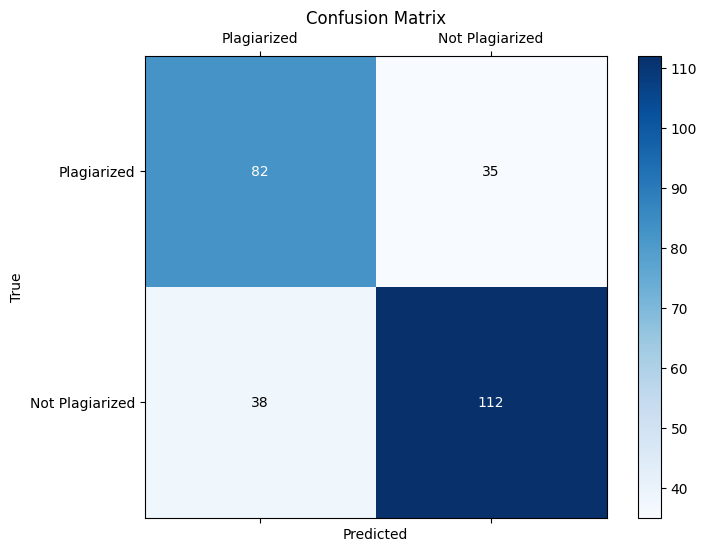

In [149]:
num_plagio = sum(1 for _, _, label in test_pairs if label == 1)
num_no_plagio = sum(1 for _, _, label in test_pairs if label == 0)

print(f"Ejemplos con plagio (1): {num_plagio}")
print(f"Ejemplos sin plagio (0): {num_no_plagio}")

cm = compute_confusion_matrix(loaded_model, test_pairs, device, batch_size=batch_size, threshold=best_threshold)
plot_confusion_matrix(cm, labels=['Plagiarized', 'Not Plagiarized'])

In [150]:
avg_loss, accuracy = evaluate(loaded_model, test_pairs, device, best_threshold, batch_size=batch_size)
print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")

Test Loss: 0.2242, Test Accuracy: 72.66%
